# Esercitazione 10

In questa esercitazione vogliamo applicare i metodi del calcolo in parallelo per andare a migliorare, e cosi' affrontare problemi di complessita' superiore, l'Algortimo Genetico creato nell'Esercitazione 9 per la risoluzione del problema del Commesso Viaggiatore.

## La Parallelizzazione

Il calcolo parallelo si basa sull'esecuzione simultanea di uno, o molteplici, programmi su più microprocessori o più core dello stesso processore. Lo scopo e' proprio quello di ridurre il tempo computazionale per l'esecuzione del programma. La programmazione, pero', si fa piu' complicata perche' bisogna suddividere un singolo problema in piu' eseguibili che devono girare in maniera efficiente su tutti i processori. \
In piu', l'efficienza dipende dall'algoritmo stesso: non tutti gli algoritmi sono ben parallelizzabili; il Monte Carlo e gli Algoritmi Genetici, pero', vanno a nozze con la parallelizzazione!

Piuttosto che scrivere diversi programmi da eseguire su piu' core in parallelo, sfrutteremo il modello SPMD, Single Program Multiple Data, dove ogni core vede lo stesso eseguibile, che quindi e' unico, ma lavora su un set differente di dati. \
Utilizzeremo la libreria MPI, Message Passing Interface, sviluppata per far interagire tra loro i nodi di esecuzione attraverso chiamate a specifiche funzioni.

## TSP in Parallelo

Riprendiamo, percio', il codice creato nell'esercitazione 9 e lo adattiamo al calcolo in parallelo per poter risolvere il problema del Commesso Viaggiatore eseguendo fino a 10 ricerche genetiche del cammino ottimale in parallelo. Ogni nodo, che chiameremo continente, eseguira' una ricerca indipendente sulla propria popolazione seguendo l'algoritmo genetico seriale in precedenza creato. \
Il processo di adattamento al calcolo in parallelo e' molto semplice dato che avevamo sfruttato una costruzione a classi che ora si mantiene invariata. \
L'unica aggiunta da fare e' una funzione, per il generatore di numeri casuali, che setta i numeri primi di generazione diversi per ogni nodo: in questo modo ogni nodo effettuera' una ricerca randomica diversa estraendo sequenze differenti di numeri casuali.

Utilizzare, pero', il calcolo parallelo solo per velocizzare algoritmi gia' scritti in seriale vuol dire non capire la potenza della Parallelizzazione; e' giusto, quindi, vedere nel calcolo parallelo una nuova opportunita' computazionale. \
Oltre ad eseguire una ricerca indipendente, implementiamo un fenomeno migratorio: tutti i continenti, ogni un numero fissato di generazioni $N_{migration}$ , si scambiano a coppie il proprio miglior individuo; dove il migliore e' ancora colui a cui corrisponde il cammino piu' corto. \
Non scambiamo piu' di un individuo per evitare perdita' di varieta' genetica nella popolazione dei continenti.

La speranza e' che, se un continente esponendo la propria popolazione al proprio ambiente riesce a far meglio degli altri nel trovare cromosomi che minimizzano la funzione costo, norma in $L^{(2)}$, prima o poi la migrazione, con lo scambio del miglior individuo, dovrebbe aiutare a convergere ad una soluzione in media migliore rispetto ad una individuata attraverso una ricerca a continenti indipendenti. Non solo, in questo modo e' molto meno probabile che un continente rimanga "incagliato" in un minimo locale perche' appena avviene lo scambio con un nodo il cui miglior individuo ha fitness maggiore, il continente comincia a far riprodurre il nuovo miglior cromosoma ed esce dal minimo locale.


Il problema che vogliamo affrontare con questo algoritmo genetico migliorato e' piu' reale e, percio', complicato: passiamo da 34 a 50 citta' la cui disposizione richiama le coordinate geografiche di cinquanta delle capitali degli Stati degli Stati Uniti d'America. \
Stiamo, quindi, cercando di risolvere il TSP in cui il nostro commesso deve visitare tutte le capitali degli stati degli USA passandoci una sola volta e tornando nella sua citta' di origine; il tutto percorrendo il tragitto piu' corto possibile.

Ovviamente l'esecuzione sfruttando il calcolo in parallelo sara' piu' efficiente rispetto al semplice algoritmo genetico dell'esercitazione 9. Percio', il nostro obiettivo e' confrontare la ricerca genetica sfruttando la parallelizzazione nel caso in cui i confini sono chiusi, non abbiamo dunque fenomeni di migrazione con lo scambio di individui, con la situazione di confini aperti identificando chi converge piu' velocemente al miglior percorso e se c'e' una differenza tra il migliore percorso trovato.

Abbiamo utilizzato popolazioni di 2000 cromosomi che si evolvono per 300 generazioni e, se lo scambio di cromosomi e' permesso, abbiamo una migrazione ogni 50 generazioni. Svolgeremo 10 ricerche genetiche in parallelo: sfrutteremo, quindi, 10 diversi core del nostro processore. \
L'algoritmo di evoluzione genetica e' indentico a quello dell'esercitazione 9 con le seguenti probabilita':
- Probabilita' di cross-over = 0.7;
- Probabilita' di Mutazione = 0.05. 

### Funzione Costo

Innanzitutto confrontiamo la simulazione a confini aperti con quella a confini chiusi dal punto di vista della funzione costo: plottiamo, nella colonna sinistra, l'andamento della funzione costo, norma in $L^{(2)}$, del miglior cammino generazione per generazione e, nella colonna destra, l'andamento di $\langle L^{(2)}\rangle$ mediato sulla meta' migliore della popolazione, anch'esso in funzione della generazione. \
Eseguiamo il confronto nodo per nodo per tutti i 10 core utilizzati.

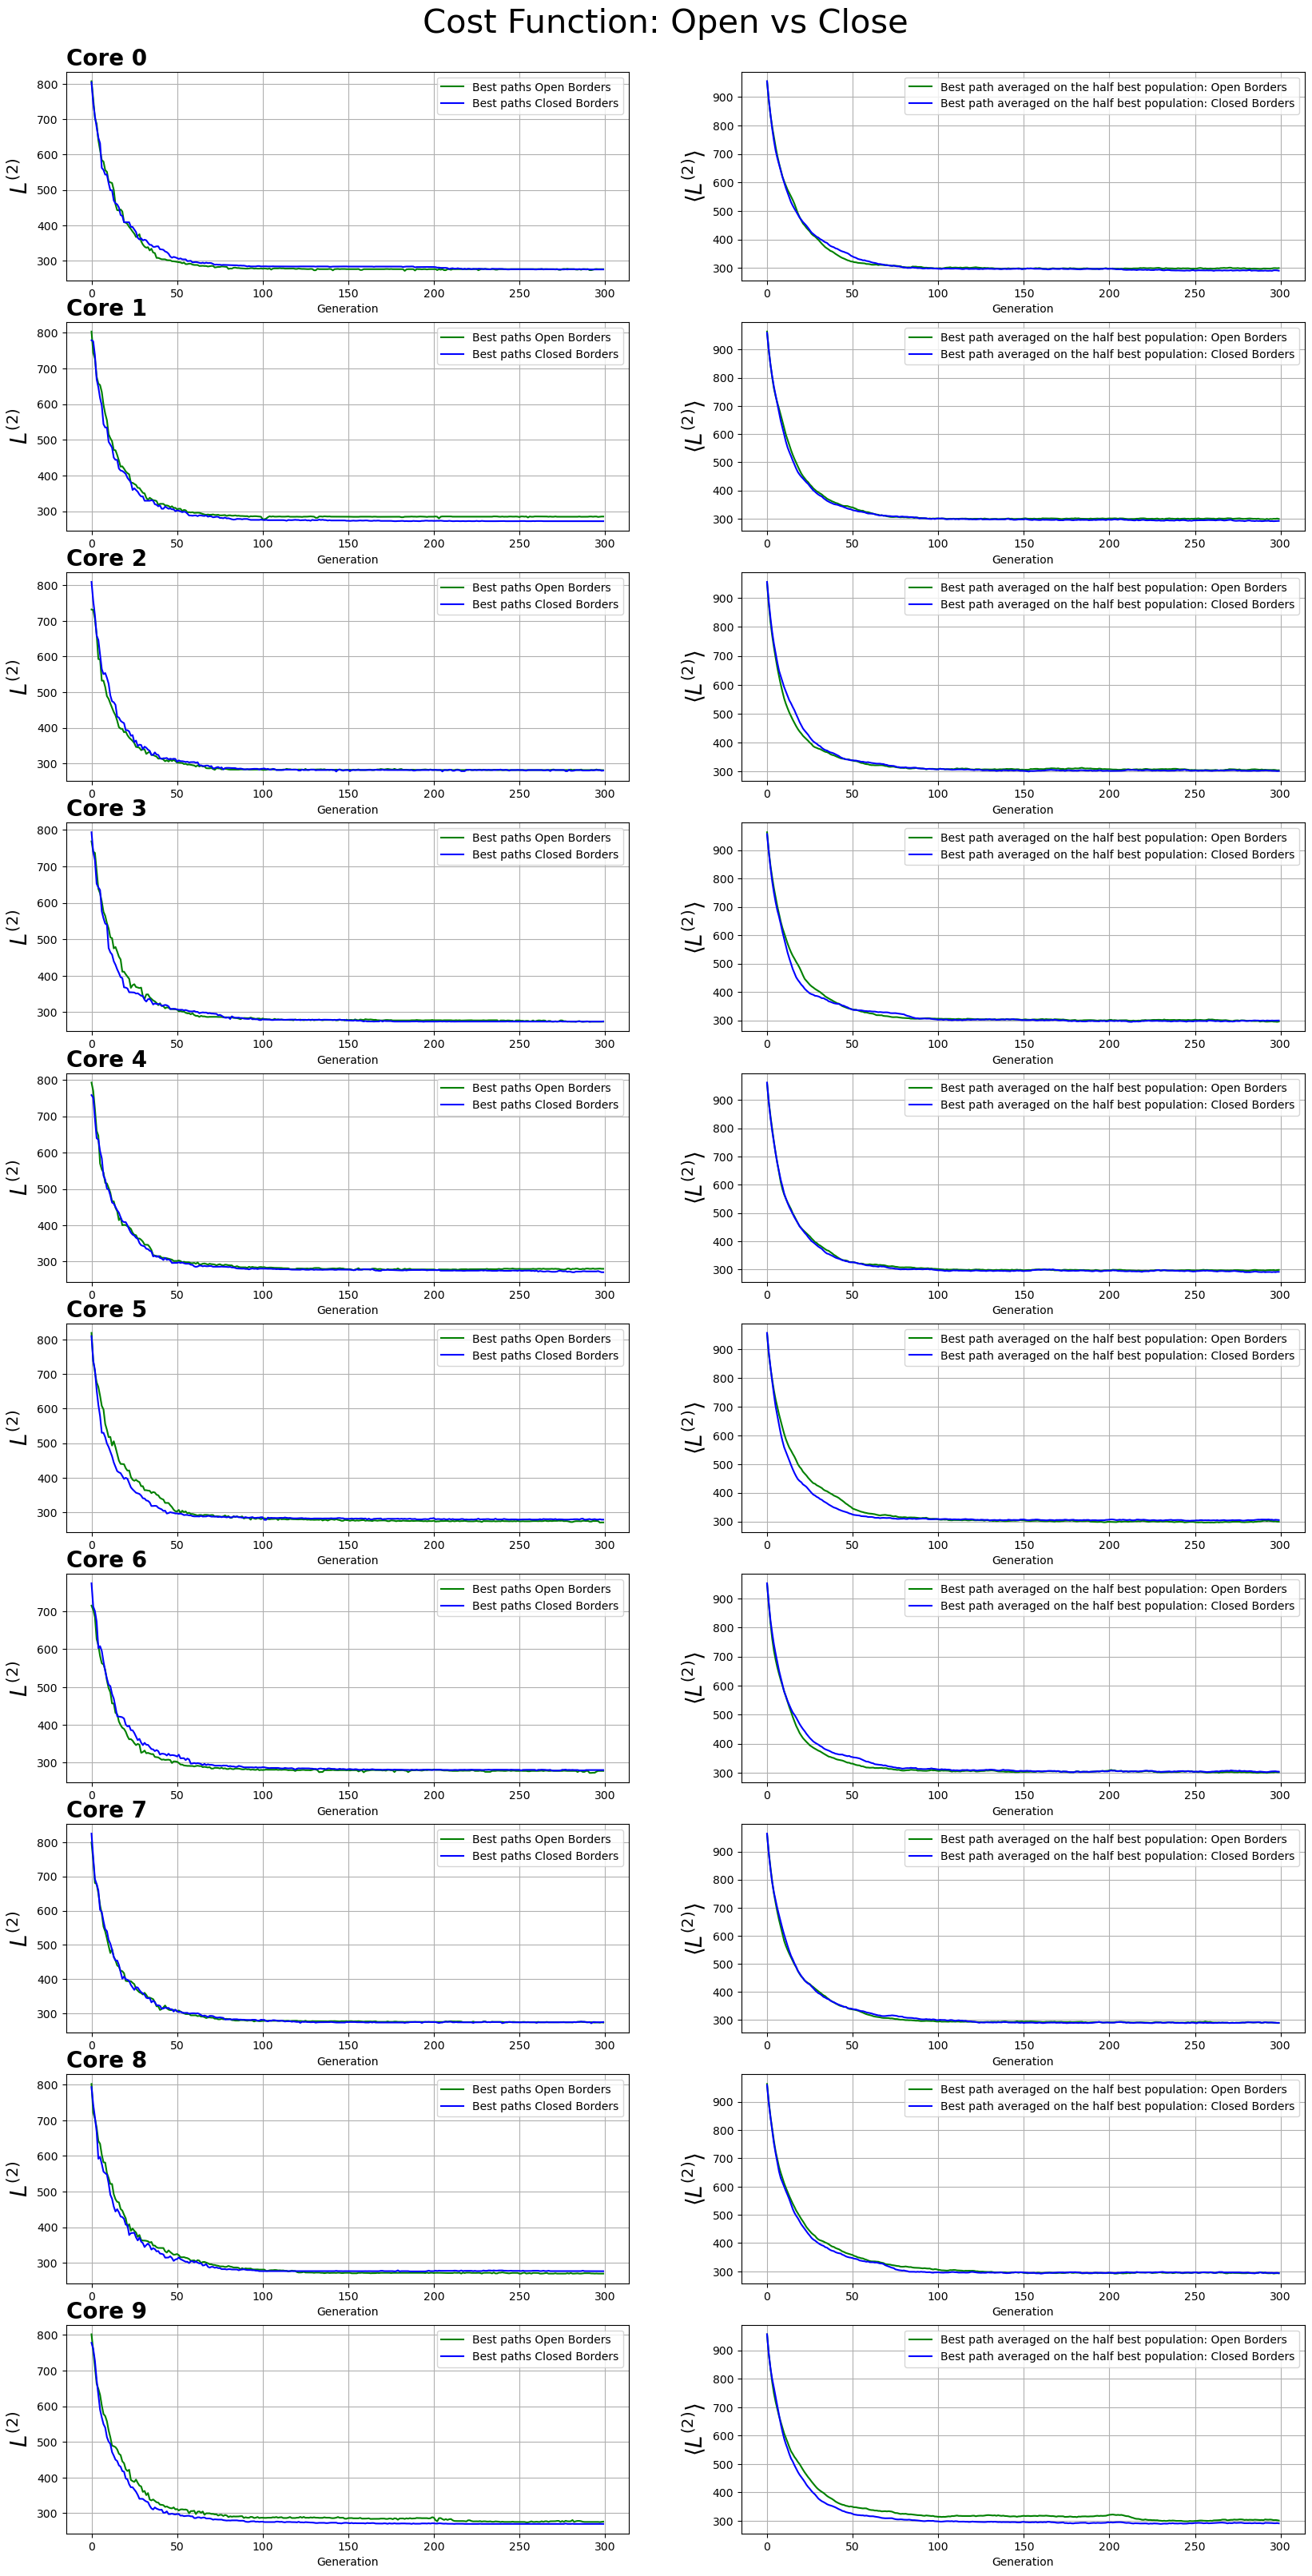

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

plt.figure(figsize=(20,40))
tracker=0
borders = ["open", "closed"]
nodes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] 
label = ["Best paths", "Best path averaged on the half best population"]
colors = ['green', 'blue']
files_name = ["distance", "average_distance"] 
y_labels = [r"$L^{(2)}$", r"$\langle L^{(2)}\rangle$"]
for i in range (20):
    plt.subplot(10, 2, i+1)
    if(i==0 or i%2==0) :
        generation_1, value_1 = np.loadtxt("es10/open/" +str(tracker)+ "_" + files_name[0]+ "_results.out", 
                  usecols=(0, 1), unpack=True, delimiter=' ')
        generation_2, value_2 = np.loadtxt("es10/closed/" +str(tracker)+ "_" + files_name[0]+ "_results.out", 
                  usecols=(0, 1), unpack=True, delimiter=' ')
        plt.plot(generation_1, value_1, label =label[0] + " Open Borders", color=colors[0])
        plt.plot(generation_2, value_2, label =label[0] + " Closed Borders", color=colors[1])
        plt.grid(True)
        plt.xlabel("Generation", fontsize=10)
        plt.ylabel(y_labels[0], fontsize=20)
        plt.title("Core " + nodes[tracker], fontweight='bold', fontsize = 20, loc ='left')
    if(i%2!=0) :
        generation_1, value_1 = np.loadtxt("es10/open/" +str(tracker)+ "_" + files_name[1]+ "_results.out", 
                  usecols=(0, 1), unpack=True, delimiter=' ')
        generation_2, value_2 = np.loadtxt("es10/closed/" +str(tracker)+ "_" + files_name[1]+ "_results.out", 
                  usecols=(0, 1), unpack=True, delimiter=' ')
        plt.plot(generation_1, value_1, label =label[1] + ": Open Borders", color=colors[0])
        plt.plot(generation_2, value_2, label =label[1] + ": Closed Borders", color=colors[1])
        plt.grid(True)
        plt.xlabel("Generation", fontsize=10)
        plt.ylabel(y_labels[1], fontsize=20)
        tracker = tracker +1
    
    plt.legend(fontsize="10")
    
plt.suptitle("Cost Function: Open vs Close", fontsize=30, y=0.9)
plt.show()

Possiamo notare come praticamente tutti i nodi, sia nel caso in cui abbiamo migrazioni tra i continenti sia quando non sono permesse, convergano verso la soluzione ottimale in meno di 100 generazioni; alcuni addirittura ci riescono in 50 generazioni. \
Il fatto che, pero', abbiamo una migrazione ogni 50 generazioni nel caso di confini aperti, insieme all'osservazione dei plot, sono una evidenza di come l'implementazione delle migrazioni non influenzi, almeno nel nostro caso, pesamentemente sulla velocita' di convergenza verso la soluzione ottimale.

Inoltre, come nell'esercitazione 9, notiamo come mediando sulla meta' migliore della popolazione il valore della funzione costo rimanga leggermente superiore al suo valore plottando il migliore cromosoma in funzione della generazione. Questo probabilmente e' dovuto al fatto stesso di andare a mediare su una popolazione ampia che potrebbe, anche al termine della simulazione, contenere al suo interno individui non ottimali.

### Miglior Cammino in Coordinate Cartesiane

Confrontiamo, ora, le due possibilita' di migrazione in coordinate cartesiane: vediamo, percio', il "vero" cammino che il nostro commesso dovrebbe seguire per minimizzare la distanza percorsa visitando tutte le capitali una sola volta e tornando nella sua citta' di origine. \
Nella colonna sinistra troviamo plottati i risulati del miglior cammino nel caso di confini aperti, mentre in quella di destra i risultati ottenuti senza fenomeni migratori. Ogni riga corriponde, invece, ad uno specifico nodo.

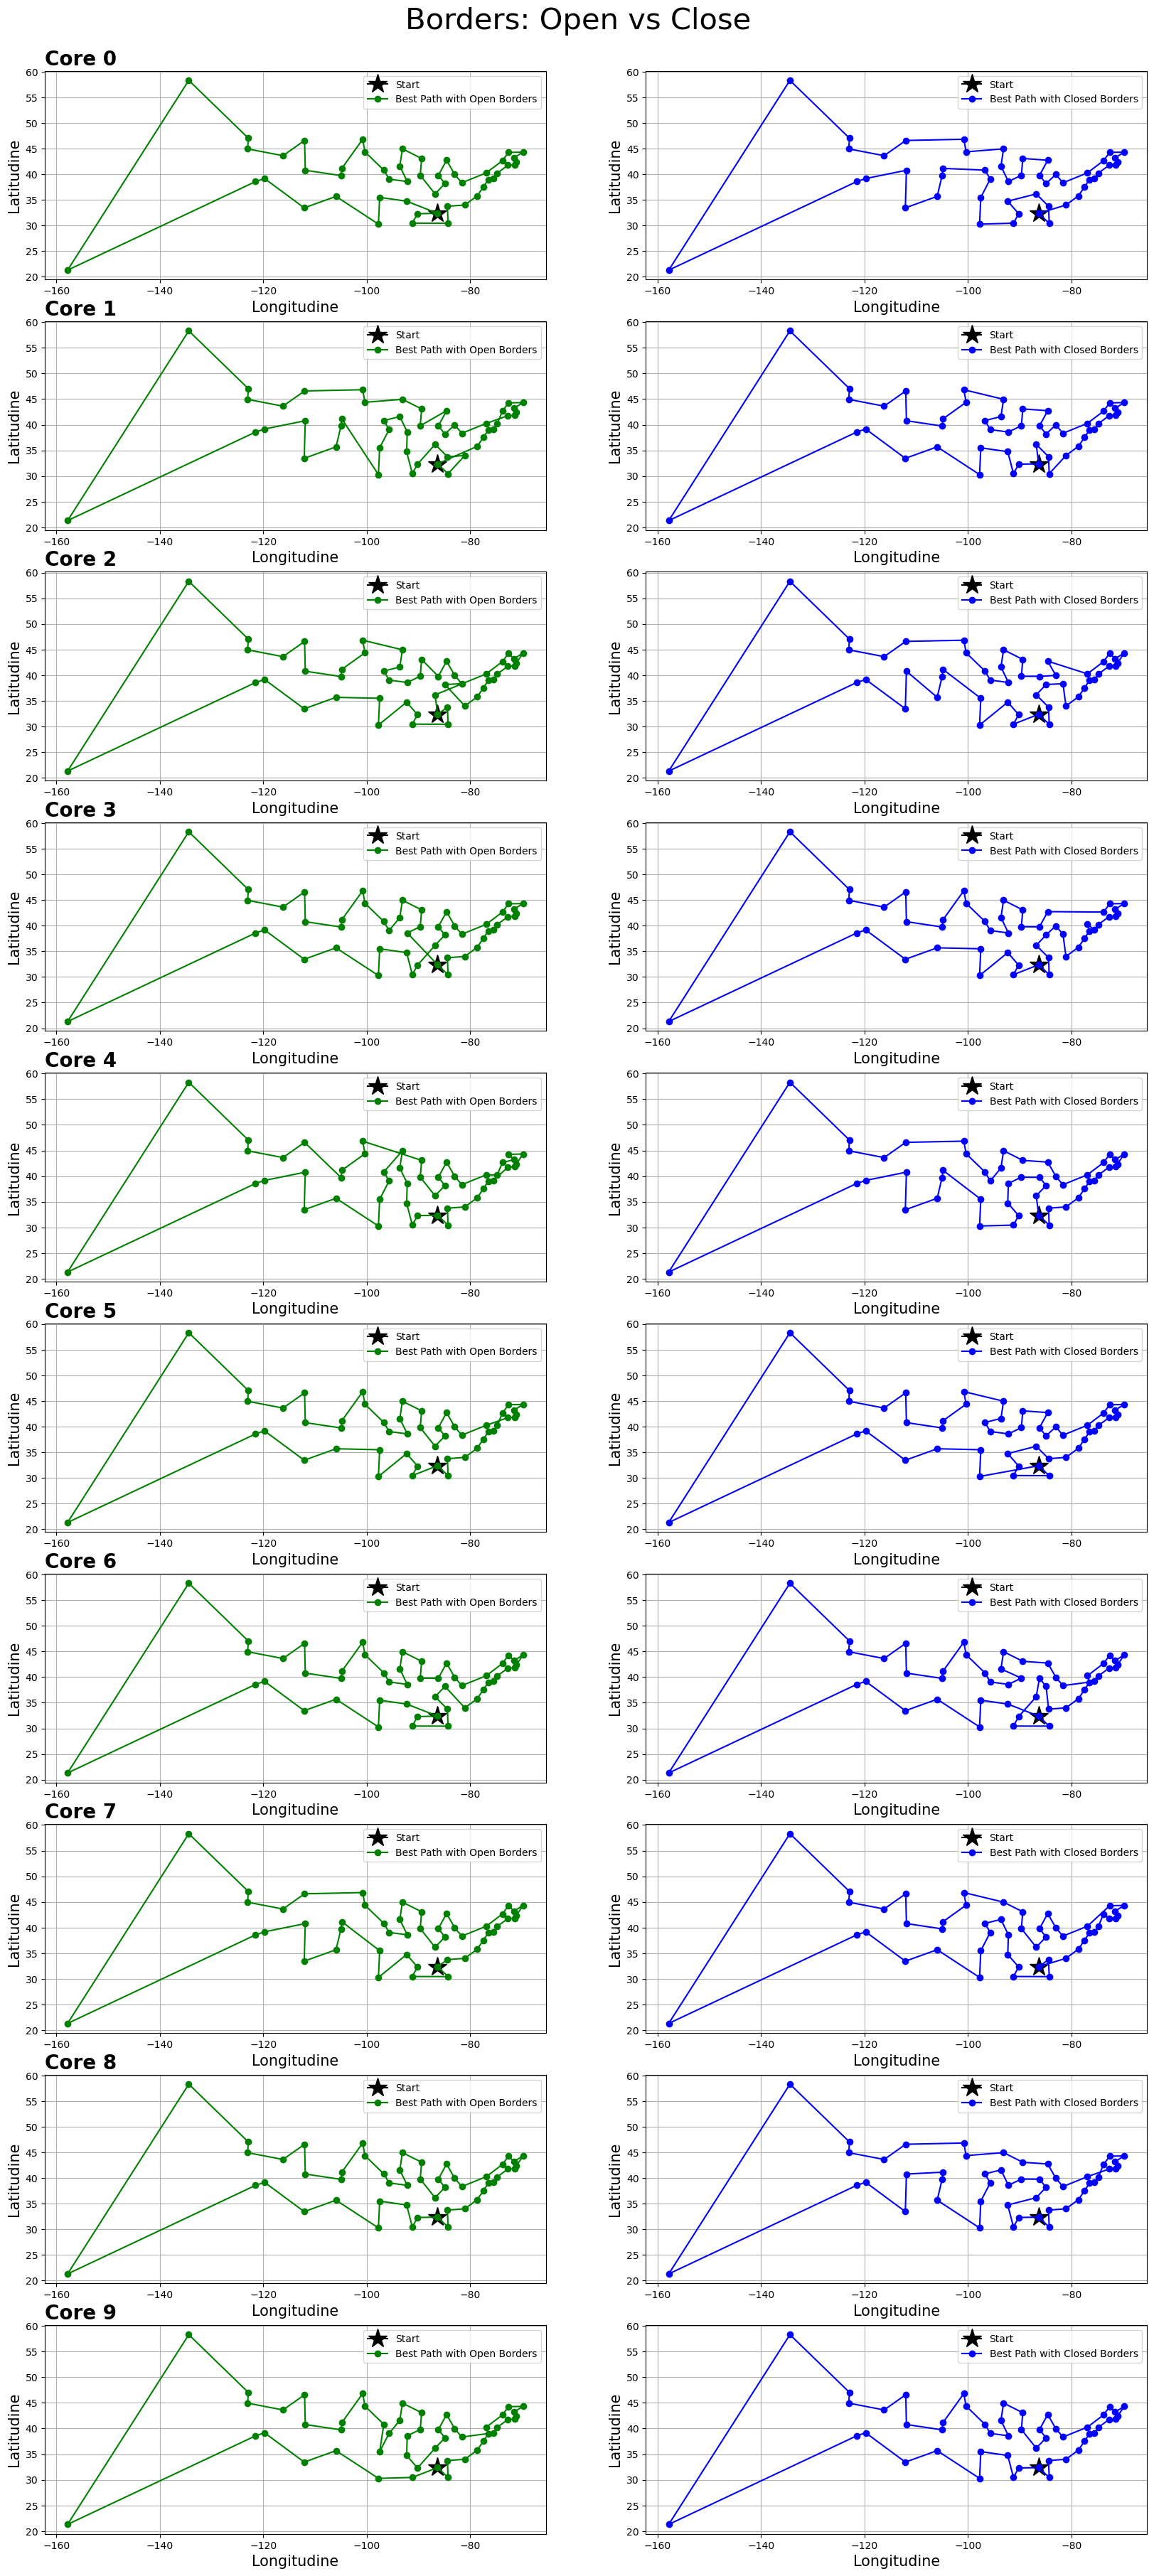

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

plt.figure(figsize=(20,45))
tracker=0
borders = ["open", "closed"]
nodes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] 
colors = ['green', 'blue']
for i in range (20): #sarebbe da mettere 20
    plt.subplot(10, 2, i+1)
    if(i==0 or i%2==0) :
        x, y = np.loadtxt("es10/open/" +str(tracker)+ "_" + "cartesian_path_results.out", 
                  usecols=(0, 1), unpack=True, delimiter=' ')
        plt.plot(x[0],y[0], marker ="*", color = "black", markersize = 20, label = "Start")
        plt.plot(x, y, label = "Best Path with Open Borders", color=colors[0], marker = 'o')
        plt.grid(True)
        plt.xlabel("Longitudine", fontsize=15)
        plt.ylabel("Latitudine", fontsize=15)
        plt.title("Core " + nodes[tracker], fontweight='bold', fontsize = 20, loc ='left')
    if(i%2!=0) :
        x, y = np.loadtxt("es10/closed/" +str(tracker)+ "_" + "cartesian_path_results.out", 
                  usecols=(0, 1), unpack=True, delimiter=' ')
        plt.plot(x[0],y[0], marker ="*", color = "black", markersize = 20, label = "Start")
        plt.plot(x, y, label = "Best Path with Closed Borders", color=colors[1], marker = 'o')
        plt.grid(True)
        plt.xlabel("Longitudine", fontsize=15)
        plt.ylabel("Latitudine", fontsize=15)
        tracker = tracker +1

    plt.legend(fontsize="10", loc ='upper right')
    
plt.suptitle("Borders: Open vs Close", fontsize=30, y=0.9)
plt.show()

Possiamo notare come per i primi passi e soprattutto nella parte centrale degli Stati Uniti, ci sia molta varieta' tra il migliore cammino in coordinate cartesiane intrapreso da ogni nodo.



Il migliore cammino in assoluto e' quello "percorso" del core 8 con lunghezza totale 269.961 in condizioni di migrazioni permesse. E' interessante notare come solo un altro core e' riuscito a convergere allo stesso valore: il core 9 in condizione, pero', di confini chiusi!

### Osservazioni

Abbiamo, ovviamente, trovato che introdurre il parallelismo su un problema genetico simile sia assolutamente vantaggioso in termini di efficienza computazionale. Sfortunatamente, pero', non siamo riusciti a verificare che la condivisione di informazioni tra i diversi core porti beneficio alla ricerca del minimo assoluto del problema. 

Probabilmente per osservare meglio l'influenza delle migrazioni dovremmo innanitutto svolgere simulazioni piu' lunghe con un importante numero di generazioni cosi' da avere piu' possibilita' di scambio e popolazioni che tendono a convergere tutte al medesimo "archetipo" di cromosoma; in piu', dovremmo calibrare piu' finemente l'algoritmo tunando in maniera piu' precisa le probabilita' di crossover e mutazione che molto influenzano l'evoluzione delle popolazioni.